## First Attempt of Shear Profile of A360 with metadetection

Contact author: Miranda Gorsuch

First attempt at creating a shear profile for A360 using cell-based coadds and `metadetection`. Many parts are from the [Shear profile around A360 using ComCam HSM shapes](https://github.com/lsst-sitcom/comcam_clusters/blob/main/ACO360_WL_HSCcalib_CLMM.ipynb) notebook, especially the identification of red sequence galaxies and use of CLMM to create the tangential shear plot.

Last working weekly: `w_2025_23`

Container Size: small (4 GB)

This is not a finished notebook and requires a lot of work yet. This is to show that the end-to-end for the generation of cell-based coadds, running `metadetection`, calibrating shears, and calculating tangential shears is almost in place.

Things to check / improve / fix
- [ ] Generate cell-based coadds in *g* bands
- [ ] Better identification and removal of RS galaxies
- [X] Removal of duplicate objects from tract / patch overlap
- [ ] Compute shape errors from `metadetect`
- [ ] Check where factor of 2 is needed for e to g conversion (shapes should already be in g)

## Imports & Definitions

In [1]:
from lsst.daf.butler import Butler

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

import gc

from lsst.skymap import Index2D
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.geom as geom

%matplotlib inline

In [2]:
REPO = '/sdf/data/rubin/repo/main/'
butler = Butler(REPO)
registry = butler.registry

# collection = 'u/mgorsuch/metadetect/comcam_Rubin_SV_38_7/20250416T020244Z'
collection = 'u/mgorsuch/metadetect/a360/20250513T210342Z' # metadetect run on two bands
cell_collection = 'u/mgorsuch/a360_cell_coadd/20250513T044026Z' # cells used as input

## Prepare data

Metadetect outputs tables for each patch. Read in each table and compile them together.

In [3]:
# Position of the BCG for A360
ra_bcg = 37.862
dec_bcg = 6.98

The cell below is for finding the tracts/patches that are within the specified radius of the BCG. This is already incorporated in the butler collection used for the `metadetect` output.

In [4]:
# skymap = butler.get('skyMap', skymap='lsst_cells_v1', collections='LSSTComCam/runs/DRP/DP1/w_2025_06/DM-48810')

# # Looking for all patches in delta deg region around it
# delta = 0.5
# center = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)
# ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
# dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

# ra_range = (ra_min, ra_max)
# dec_range = (dec_min, dec_max)
# radec = [geom.SpherePoint(ra_range[0], dec_range[0], geom.degrees),
#          geom.SpherePoint(ra_range[0], dec_range[1], geom.degrees),
#          geom.SpherePoint(ra_range[1], dec_range[0], geom.degrees),
#          geom.SpherePoint(ra_range[1], dec_range[1], geom.degrees)]

# tractPatchList = skymap.findTractPatchList(radec)

# find dataset refs that are within the tract/patch list above
# datasetRefs_shear = []
# datasetRefs_catalog = []

# for tractPatch in tractPatchList:
#     tract = tractPatch[0]
#     patchInfo = tractPatch[1]
#     for patch in patchInfo:
#         datasetRefs_shear.append(butler.query_datasets('ShearObject', 
#                                                  collections=collection,
#                                                  tract=tract.tract_id,
#                                                  patch=patch.sequential_index))
#         datasetRefs_catalog.append(butler.query_datasets('objectTable', 
#                                                  collections=default_collection,
#                                                  tract=tract.tract_id,
#                                                  patch=patch.sequential_index))

In [5]:
datasetRefs_shear = []
overlap_patches_10463 = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
tract_patch_list = [] # only used for plotting distribution of input images

for ref in butler.registry.queryDatasets('ShearObject', collections=collection):

    if ref.dataId['tract'] == 10704 or ref.dataId['tract'] == 10705:
        continue

    if ref.dataId['tract'] == 10463 and ref.dataId['patch'] in overlap_patches_10463:
        continue
    
    datasetRefs_shear.append(butler.query_datasets('ShearObject', 
                                                     collections=collection,
                                                     skymap = 'lsst_cells_v1',
                                                     tract=ref.dataId['tract'],
                                                     patch=ref.dataId['patch']))

    tract_patch_list.append([ref.dataId['tract'], ref.dataId['patch']])

In [6]:
shear_table_list = []

for i, ref in enumerate(datasetRefs_shear):
    shear_data_patch = butler.get(ref[0])
    shear_table_patch = shear_data_patch.to_pandas()
    shear_table_list.append(shear_table_patch)

shear_table = pd.concat(shear_table_list)

# remove unused tables to clear up memory
del shear_table_list
gc.collect()

151

In [7]:
# remove objects in outer ring of cells in each patch since patch overlap is two cells
shear_table = shear_table[shear_table['cell_x']!=0]
shear_table = shear_table[shear_table['cell_x']!=21]
shear_table = shear_table[shear_table['cell_y']!=0]
shear_table = shear_table[shear_table['cell_y']!=21]
print("Number of rows after removing most duplicate cells: ", len(shear_table))

filt1 = shear_table['tract'] == 10463
filt1 &= shear_table['patch_x'] == 0
filt1 &= shear_table['cell_x'] == 1
shear_table = shear_table[np.invert(filt1)]

filt2 = shear_table['tract'] == 10463
filt2 &= shear_table['patch_x'] == 0
filt2 &= shear_table['cell_x'] == 2
shear_table = shear_table[np.invert(filt2)]
print("Number of rows after removing patch overlap in 10463: ", len(shear_table))

# some patch overlap appears to have a 6(?) cell overlap
filt3 = shear_table['tract'] == 10464
filt3 &= shear_table['patch_x'] == 9
filt3 &= shear_table['cell_x'] == 20
shear_table = shear_table[np.invert(filt3)]

# some patch overlap appears to have a 4 cell overlap
filt4 = shear_table['tract'] == 10464
filt4 &= shear_table['patch_x'] == 9
filt4 &= shear_table['cell_x'] == 19
shear_table = shear_table[np.invert(filt4)]
print("Number of rows after removing patch overlap in 10464: ", len(shear_table))

Number of rows after removing most duplicate cells:  395814
Number of rows after removing patch overlap in 10463:  395814
Number of rows after removing patch overlap in 10464:  389274


In [8]:
# remove exact duplicates   
print("Number of rows prior to removing duplicates: ", len(shear_table))
shear_table= shear_table.drop_duplicates(subset=['shear_type', 'ra', 'dec']) # each object will potentially have several sheared images
print("Number of rows after removing duplicates: ", len(shear_table))

Number of rows prior to removing duplicates:  389274
Number of rows after removing duplicates:  387150


In [9]:
# make new columns to convert nJy fluxes to AB magnitudes
t1 = Table.from_pandas(shear_table)

t1['wmom_band_mag_r'] = (t1['wmom_band_flux_r']*u.nJy).to(u.ABmag)
t1['wmom_band_mag_i'] = (t1['wmom_band_flux_i']*u.nJy).to(u.ABmag)
t1['wmom_color_mag_r-i'] = t1['wmom_band_mag_r']-t1['wmom_band_mag_i']

shear_table = t1.to_pandas()

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


### Plot distribution of input images per cell in A360 region

Not needed for the shear analysis, but may be a useful reference.

In [10]:
from lsst.sphgeom import Box, HealpixPixelization
import healsparse as hsp
import healpy as hp
from hpgeom import hpgeom
import skyproj

In [11]:
# define healpix parameters
nside_coverage = 2**8
nside_sparse = 2**14

pixelization = HealpixPixelization(hp.nside2order(nside_sparse))

In [12]:
# method find the pixel indices that overlap the sky projection of the cell area
def get_cell_pixels(cell, wcs):
    cell_bbox = cell.inner.bbox
    begin_coord = wcs.pixelToSky(cell_bbox.beginX, cell_bbox.beginY)
    end_coord = wcs.pixelToSky(cell_bbox.endX, cell_bbox.endY)
    
    if begin_coord.getRa() < end_coord.getRa():
        ra1 = begin_coord.getRa().asDegrees()
        ra2 = end_coord.getRa().asDegrees()
    else:
        ra1 = end_coord.getRa().asDegrees()
        ra2 = begin_coord.getRa().asDegrees()
    
    if begin_coord.getDec() < end_coord.getDec():
        dec1 = begin_coord.getDec().asDegrees()
        dec2 = end_coord.getDec().asDegrees()
    else:
        dec1 = end_coord.getDec().asDegrees()
        dec2 = begin_coord.getDec().asDegrees()

    indices = hpgeom.query_box(nside=nside_sparse, a0=ra1, a1=ra2, b0=dec1, b1=dec2)
    
    return indices

In [13]:
def get_cell_inputs(cell_collection, tract_patch_list, band):

    cell_df = pd.DataFrame()
    cell_ra = []
    cell_dec = []
    pixel_indices = []
    inputs_list = []

    segs = [] # collection of lines to plot patch outlines

    for tract, patch in tract_patch_list:
    
        coadd = butler.get('deepCoaddCell', 
                         collections = cell_collection, 
                         instrument = 'LSSTComCam', 
                         skymap = 'lsst_cells_v1', 
                         tract = tract, 
                         patch = patch,
                         band = band,)
        # define a wcs from the given coadd
        wcs = coadd.wcs

        # get coadd outline
        coadd_corners = coadd.inner_bbox.getCorners()
    
        for index, corner in enumerate(coadd_corners):
            corner_coord_start = wcs.pixelToSky(corner.getX(), corner.getY())
            if index < 3:
                corner_coord_end = wcs.pixelToSky(coadd_corners[index+1].getX(), coadd_corners[index+1].getY())
            else:
                corner_coord_end = wcs.pixelToSky(coadd_corners[0].getX(), coadd_corners[0].getY())
    
            start_ra = corner_coord_start[0].asDegrees()
            start_dec = corner_coord_start[1].asDegrees()
    
            end_ra = corner_coord_end[0].asDegrees()
            end_dec = corner_coord_end[1].asDegrees()
    
            segs.append(((start_ra, start_dec), (end_ra, end_dec)))
        
        cell_list = list(coadd.cells.keys()) # skips indices that are empty

        # for each cell in cell_list:
        for index, cell_index in enumerate(cell_list):
    
            cell = coadd.cells[cell_index]
    
            # get cell coordinates for removing duplicates
            cell_center = cell.inner.bbox.getCenter()
            cell_center_coord = wcs.pixelToSky(cell_center)
            cell_ra.append(cell_center_coord.getRa().asDegrees())
            cell_dec.append(cell_center_coord.getDec().asDegrees())
        
            pixel_indices.append(get_cell_pixels(cell, wcs))
    
            inputs_list.append(cell.visit_count)
    
        del coadd
        gc.collect()
    
    cell_df["ra"] = cell_ra
    cell_df["dec"] = cell_dec
    cell_df["pixels"] = pixel_indices
    cell_df["inputs"] = inputs_list

    return cell_df, segs

Skipping the next few cells since they are running fairly slow at the moment (26+ min when it should take 3-4 min.)

#### i-band

In [ ]:
cell_df_i, segs_i = get_cell_inputs(cell_collection, tract_patch_list, 'i')

In [ ]:
# remove duplicate cells from overlapping patches
cell_df_i = cell_df_i.drop_duplicates(subset=['ra', 'dec'])

In [ ]:
pixel_df_i = cell_df_i.explode('pixels').reset_index(drop=True)
pixel_df_i = pixel_df_i.drop_duplicates(subset=["pixels"]) 
pixel_df_i = pixel_df_i.dropna(subset=['pixels'])

pixels_i = pixel_df_i["pixels"].to_numpy()
pixel_input_i = pixel_df_i["inputs"].to_numpy()

In [ ]:
hsp_map_input_i = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)
hsp_map_input_i.update_values_pix(np.array(pixels_i, dtype=np.int64), np.array(pixel_input_i))

#### r-band

In [ ]:
cell_df_r, segs_r = get_cell_inputs(cell_collection, tract_patch_list, 'r')

In [ ]:
# remove duplicate cells from overlapping patches
cell_df_r = cell_df_r.drop_duplicates(subset=['ra', 'dec'])

In [ ]:
pixel_df_r = cell_df_r.explode('pixels').reset_index(drop=True)
pixel_df_r = pixel_df_r.drop_duplicates(subset=["pixels"]) 
pixel_df_r = pixel_df_r.dropna(subset=['pixels'])

pixels_r = pixel_df_r["pixels"].to_numpy()
pixel_input_r = pixel_df_r["inputs"].to_numpy()

In [ ]:
hsp_map_input_r = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)
hsp_map_input_r.update_values_pix(np.array(pixels_r, dtype=np.int64), np.array(pixel_input_r))

#### Input Distribution Plot

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5.3))
sp_i = skyproj.GnomonicSkyproj(ax=ax[0], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_i.draw_hspmap(hsp_map_input_i)
sp_i.ax.set_xlabel("RA", fontsize=10,)
sp_i.ax.set_ylabel("DEC", fontsize=10,)
sp_i.draw_colorbar(shrink=0.9, label='Number of input warps per cell')
sp_i.ax.set_title("i-band", pad=25)
for seg in segs_i:
    sp_i.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

sp_r = skyproj.GnomonicSkyproj(ax=ax[1], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_r.draw_hspmap(hsp_map_input_r)
sp_r.ax.set_xlabel("RA", fontsize=10,)
sp_r.ax.set_ylabel("DEC", fontsize=10,)
sp_r.draw_colorbar(shrink=0.9, label='Number of input warps per cell')
sp_r.ax.set_title("r-band", pad=25)
for seg in segs_r:
    sp_r.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

plt.suptitle("Cell Input Distribution of the A360 Region")
plt.show()

The two missing patches were due to pipeline failures, though are not included within the 0.5 degree radius of the BCG

## Apply `metadetect` flags

Anything that is flagged should be removed.

In [14]:
print(shear_table['wmom_flags'].unique())
print(shear_table['psfrec_flags'].unique())
print(shear_table['wmom_psf_flags'].unique())
print(shear_table['wmom_obj_flags'].unique())
print(shear_table['wmom_T_flags'].unique())
print(shear_table['wmom_band_flux_flags_r'].unique())
print(shear_table['wmom_band_flux_flags_i'].unique())

[ 1048576        0  2097156 33554432]
[0]
[ 1  0 64]
[      1       0 2097156]
[1 0 4]
[1 0]
[1 0]


In [15]:
meta_filter = shear_table['wmom_flags']==False
meta_filter &= shear_table['psfrec_flags']==False
meta_filter &= shear_table['wmom_psf_flags']==False
meta_filter &= shear_table['wmom_obj_flags']==False
meta_filter &= shear_table['wmom_T_flags']==False
meta_filter &= shear_table['wmom_band_flux_flags_r']==False
meta_filter &= shear_table['wmom_band_flux_flags_i']==False

shear_table = shear_table[meta_filter]

print("Number of rows after removing metadetect flags: ", len(shear_table))

Number of rows after removing metadetect flags:  314428


## Quality cuts

Using cuts from [Yamamoto 2024](https://arxiv.org/abs/2501.05665) for
- Star/galaxy separation
- S/N
- Size (visually check first if needed)
- Flux
- Color

These may need to be updated provided this is a different dataset, but should be a good starting point.

(It looks like the metadetect flags applied already take these into account?)

**Note: the Yamamoto paper cut for object size is definited differently than the Metadetect columns, so the object size cut from the DES code is used instead https://github.com/des-science/des-y6utils/blob/main/des_y6utils/mdet.py#L268**

In [16]:
# print("Object size ratio rows removed: ", len(shear_table)-len(shear_table[shear_table['wmom_T_ratio']>0.5]))
print("Object size ratio rows removed: ", len(shear_table)-len(shear_table[shear_table['wmom_T_ratio']>1.2]))
print("S/N ratio rows removed: ", len(shear_table)-len(shear_table[shear_table['wmom_s2n']>10]))
print("Size rows removed: ", len(shear_table)-len(shear_table[shear_table['wmom_T']<20]))
print("m_frac rows removed: ", len(shear_table)-len(shear_table[shear_table['mfrac']<0.1]))
# print("faint in r-band removed: ", len(shear_table)-len(shear_table[shear_table['wmom_band_mag_r']<26.5]))
# print("faint in i-band removed: ", len(shear_table)-len(shear_table[shear_table['wmom_band_mag_i']<24.7]))
# print("faint in r-band removed: ", len(shear_table)-len(shear_table[shear_table['wmom_band_mag_r']<25.0]))
print("faint in i-band removed: ", len(shear_table)-len(shear_table[shear_table['wmom_band_mag_i']<24.5])) # trying for brighter objects
print("r-i flux rows removed: ", 
      len(shear_table)-len(shear_table[(shear_table['wmom_band_mag_r']-shear_table['wmom_band_mag_i']).abs()<5]))

Object size ratio rows removed:  202465
S/N ratio rows removed:  0
Size rows removed:  0
m_frac rows removed:  0
faint in i-band removed:  521
r-i flux rows removed:  157


In [17]:
# q_cuts = shear_table['wmom_T_ratio']>0.5
q_cuts = shear_table['wmom_T_ratio']>1.2
q_cuts &= shear_table['wmom_s2n']>10
q_cuts &= shear_table['wmom_T']<20
q_cuts &= shear_table['mfrac']<0.1
# q_cuts &= shear_table['wmom_band_mag_r']<25.0
q_cuts &= shear_table['wmom_band_mag_i']<24.5
q_cuts &= (shear_table['wmom_band_mag_r']-shear_table['wmom_band_mag_i']).abs()<5

shear_table = shear_table[q_cuts]

print("Number of rows after applying quality cuts: ", len(shear_table))

Number of rows after applying quality cuts:  111767


## Check shear types for each object

Each object is detected and measured separately for each sheared/unsheared image. The catalogs will not necessarily be the same but should be close in number of objects.

In [18]:
print("Number of shear type 'ns': ", len(shear_table[shear_table['shear_type']=='ns']))
print("Number of shear type '1p': ", len(shear_table[shear_table['shear_type']=='1p']))
print("Number of shear type '1m': ", len(shear_table[shear_table['shear_type']=='1m']))
print("Number of shear type '2p': ", len(shear_table[shear_table['shear_type']=='2p']))
print("Number of shear type '2m': ", len(shear_table[shear_table['shear_type']=='2m']))

Number of shear type 'ns':  22325
Number of shear type '1p':  22295
Number of shear type '1m':  22363
Number of shear type '2p':  22365
Number of shear type '2m':  22419


## Identify and remove cluster member galaxies

This should be done for each shear type catalog individually.

### Add column for degree separation from BCG

In [19]:
c1 = SkyCoord(shear_table['ra'].values*u.deg, shear_table['dec'].values*u.deg)
c2 = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
sep = c1.separation(c2)

shear_table['deg_sep'] = sep.value

### Split table by shear types

In [20]:
shear_table_ns = shear_table[shear_table['shear_type']=='ns']
shear_table_1p = shear_table[shear_table['shear_type']=='1p']
shear_table_1m = shear_table[shear_table['shear_type']=='1m']
shear_table_2p = shear_table[shear_table['shear_type']=='2p']
shear_table_2m = shear_table[shear_table['shear_type']=='2m']

### Filter objects to within < 0.1 deg of cluster center

In [21]:
filt = shear_table['deg_sep'] < 0.1 # stay close to cluster center for RS indentification
shear_table_rs_ns = shear_table_ns[shear_table_ns['deg_sep'] < 0.1] # catalog for RS identification
shear_table_rs_1p = shear_table_1p[shear_table_1p['deg_sep'] < 0.1]
shear_table_rs_1m = shear_table_1m[shear_table_1m['deg_sep'] < 0.1]
shear_table_rs_2p = shear_table_2p[shear_table_2p['deg_sep'] < 0.1]
shear_table_rs_2m = shear_table_2m[shear_table_2m['deg_sep'] < 0.1]
print("Number of rows in ns after applying < 0.1 deg from center: ", len(shear_table_rs_ns))
print("Number of rows in 1p after applying < 0.1 deg from center: ", len(shear_table_rs_1p))
print("Number of rows in 1m after applying < 0.1 deg from center: ", len(shear_table_rs_1m))
print("Number of rows in 2p after applying < 0.1 deg from center: ", len(shear_table_rs_2p))
print("Number of rows in 2m after applying < 0.1 deg from center: ", len(shear_table_rs_2m))

Number of rows in ns after applying < 0.1 deg from center:  626
Number of rows in 1p after applying < 0.1 deg from center:  633
Number of rows in 1m after applying < 0.1 deg from center:  624
Number of rows in 2p after applying < 0.1 deg from center:  628
Number of rows in 2m after applying < 0.1 deg from center:  618


### Color-magnitude diagram

Identify red sequence by eye for now.

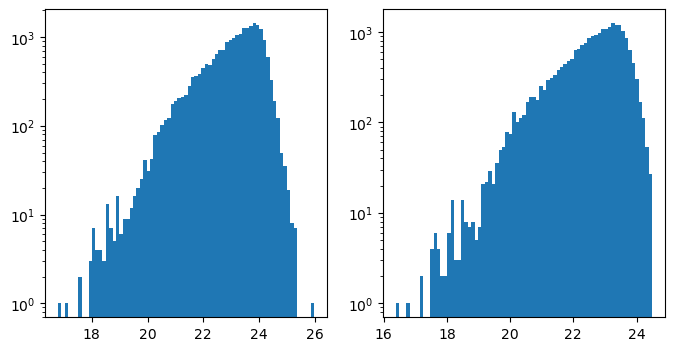

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].hist(shear_table_ns['wmom_band_mag_r'], bins=75)
ax[1].hist(shear_table_ns['wmom_band_mag_i'], bins=75)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

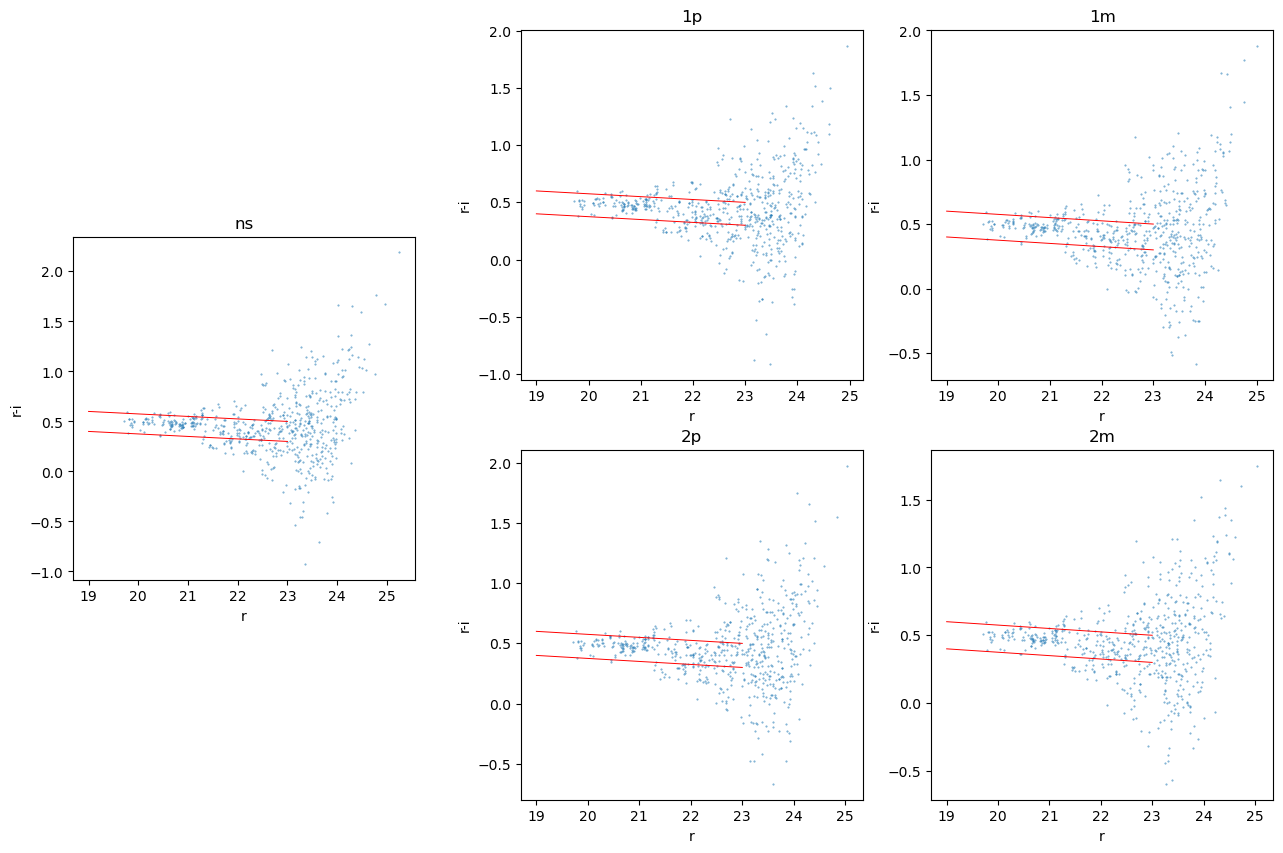

In [23]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes[1][0].set_visible(False)

axes[0][0].set_position([0.1,0.33,0.228,0.343])

point_size = 0.8
point_alpha = 0.7

# ns 
axes[0][0].scatter(shear_table_rs_ns['wmom_band_mag_r'], shear_table_rs_ns['wmom_color_mag_r-i'], 
           marker='.', s=point_size, alpha=point_alpha)
axes[0][0].set_title("ns")

axes[0][1].scatter(shear_table_rs_1p['wmom_band_mag_r'], shear_table_rs_1p['wmom_color_mag_r-i'], 
           marker='.', s=point_size, alpha=point_alpha)
axes[0][1].set_title("1p")

axes[0][2].scatter(shear_table_rs_1m['wmom_band_mag_r'], shear_table_rs_1m['wmom_color_mag_r-i'], 
           marker='.', s=point_size, alpha=point_alpha)
axes[0][2].set_title("1m")

axes[1][1].scatter(shear_table_rs_2p['wmom_band_mag_r'], shear_table_rs_2p['wmom_color_mag_r-i'], 
           marker='.', s=point_size, alpha=point_alpha)
axes[1][1].set_title("2p")

axes[1][2].scatter(shear_table_rs_2m['wmom_band_mag_r'], shear_table_rs_2m['wmom_color_mag_r-i'], 
           marker='.', s=point_size, alpha=point_alpha)
axes[1][2].set_title("2m")

# apply formatting to all subplots
for ax in fig.axes:
    ax.set_ylabel('r-i')
    ax.set_xlabel('r')
    # ax.set_ylim([-1.5,2.5])
    # ax.set_xlim([17,24.5])
    # ax.set_ylim([-2,2])
    # ax.set_xlim([19,25])
    # ax.set_ylim([-0.5,1.0])
    # ax.set_xlim([18.5,24])
    ax.plot([19,23],[0.4,0.3], color='r', linewidth=0.7)
    ax.plot([19,23],[0.6,0.5], color='r', linewidth=0.7)

Note that combining all catalogs causes a "smeary" look is due to the 5 sheared/unsheared images of the same object that are detected & measured in slightly different ways.

### Filter RS galaxies

In [24]:
rs_hi_ns = 0.6 - (0.1/5.) * (shear_table_rs_ns['wmom_band_mag_r']-19)
rs_low_ns = 0.4 - (0.1/5.)* (shear_table_rs_ns['wmom_band_mag_r']-19)
color_ns = shear_table_rs_ns['wmom_color_mag_r-i']
idx_ns = np.where(np.logical_and(color_ns>rs_low_ns, color_ns<rs_hi_ns))[0]
idx2_ns = np.where(shear_table_rs_ns['wmom_band_mag_r'].iloc[idx_ns] < 23)[0] # keep the brightest objects only

rs_hi_1p = 0.6 - (0.1/5.) * (shear_table_rs_1p['wmom_band_mag_r']-19)
rs_low_1p = 0.4 - (0.1/5.)* (shear_table_rs_1p['wmom_band_mag_r']-19)
color_1p = shear_table_rs_1p['wmom_color_mag_r-i']
idx_1p = np.where(np.logical_and(color_1p>rs_low_1p, color_1p<rs_hi_1p))[0]
idx2_1p = np.where(shear_table_rs_1p['wmom_band_mag_r'].iloc[idx_1p] < 23)[0] # keep the brightest objects only

rs_hi_1m = 0.6 - (0.1/5.) * (shear_table_rs_1m['wmom_band_mag_r']-19)
rs_low_1m = 0.4 - (0.1/5.)* (shear_table_rs_1m['wmom_band_mag_r']-19)
color_1m = shear_table_rs_1m['wmom_color_mag_r-i']
idx_1m = np.where(np.logical_and(color_1m>rs_low_1m, color_1m<rs_hi_1m))[0]
idx2_1m = np.where(shear_table_rs_1m['wmom_band_mag_r'].iloc[idx_1m] < 23)[0] # keep the brightest objects only

rs_hi_2p = 0.6 - (0.1/5.) * (shear_table_rs_2p['wmom_band_mag_r']-19)
rs_low_2p = 0.4 - (0.1/5.)* (shear_table_rs_2p['wmom_band_mag_r']-19)
color_2p = shear_table_rs_2p['wmom_color_mag_r-i']
idx_2p = np.where(np.logical_and(color_2p>rs_low_2p, color_2p<rs_hi_2p))[0]
idx2_2p = np.where(shear_table_rs_2p['wmom_band_mag_r'].iloc[idx_2p] < 23)[0] # keep the brightest objects only

rs_hi_2m = 0.6 - (0.1/5.) * (shear_table_rs_2m['wmom_band_mag_r']-19)
rs_low_2m = 0.4 - (0.1/5.)* (shear_table_rs_2m['wmom_band_mag_r']-19)
color_2m = shear_table_rs_2m['wmom_color_mag_r-i']
idx_2m = np.where(np.logical_and(color_2m>rs_low_2m, color_2m<rs_hi_2m))[0]
idx2_2m = np.where(shear_table_rs_2m['wmom_band_mag_r'].iloc[idx_2m] < 23)[0] # keep the brightest objects only

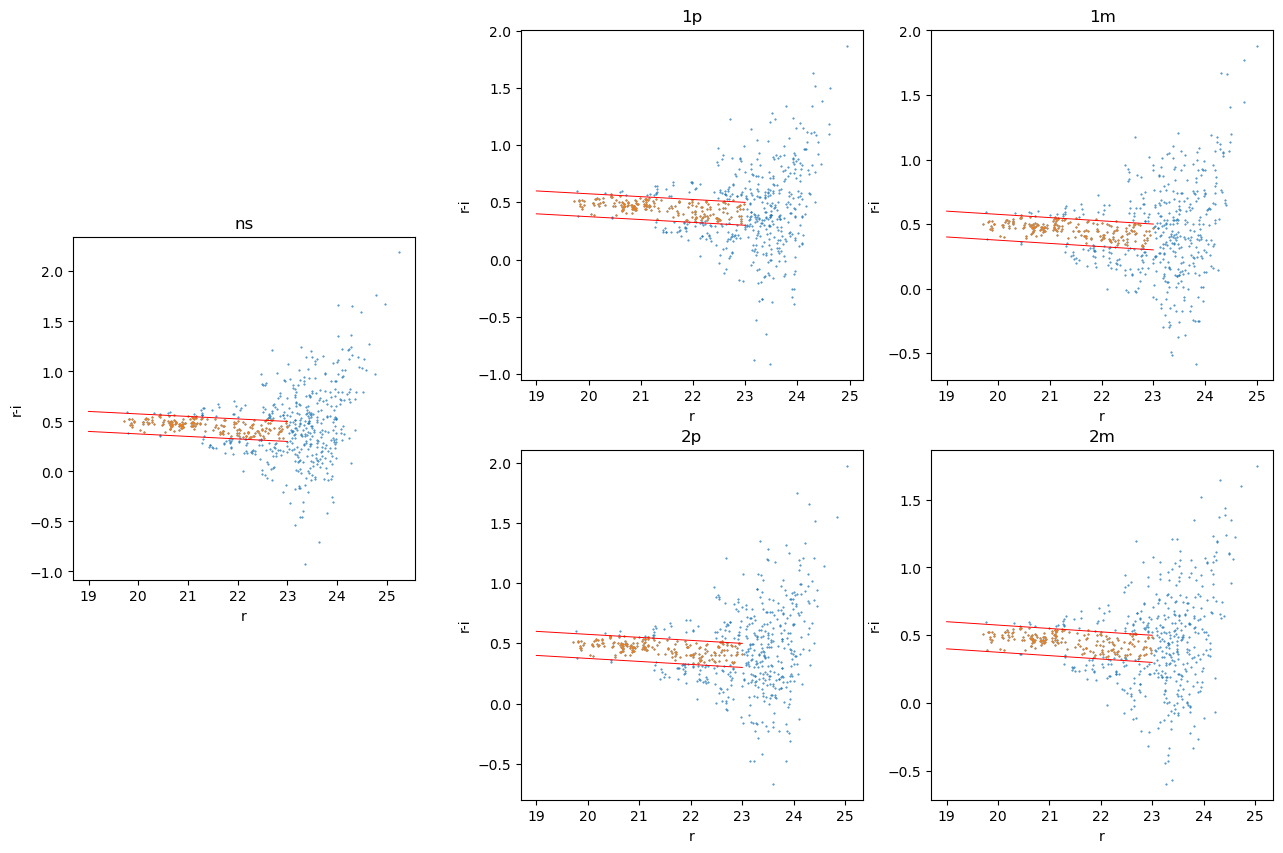

In [25]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes[1][0].set_visible(False)

axes[0][0].set_position([0.1,0.33,0.228,0.343])

point_size = 0.8
point_alpha = 0.7

# ns 
axes[0][0].scatter(shear_table_rs_ns['wmom_band_mag_r'], shear_table_rs_ns['wmom_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0][0].scatter(shear_table_rs_ns['wmom_band_mag_r'].iloc[idx_ns].iloc[idx2_ns], 
           shear_table_rs_ns['wmom_band_mag_r'].iloc[idx_ns].iloc[idx2_ns]-shear_table_rs_ns['wmom_band_mag_i'].iloc[idx_ns].iloc[idx2_ns], 
           marker='.', s=point_size) #red sequence galaxies
axes[0][0].set_title("ns")

# 1p
axes[0][1].scatter(shear_table_rs_1p['wmom_band_mag_r'], shear_table_rs_1p['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[0][1].scatter(shear_table_rs_1p['wmom_band_mag_r'].iloc[idx_1p].iloc[idx2_1p], 
           shear_table_rs_1p['wmom_band_mag_r'].iloc[idx_1p].iloc[idx2_1p]-shear_table_rs_1p['wmom_band_mag_i'].iloc[idx_1p].iloc[idx2_1p], 
           marker='.', s=point_size)
axes[0][1].set_title("1p")

# 1m
axes[0][2].scatter(shear_table_rs_1m['wmom_band_mag_r'], shear_table_rs_1m['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[0][2].scatter(shear_table_rs_1m['wmom_band_mag_r'].iloc[idx_1m].iloc[idx2_1m], 
           shear_table_rs_1m['wmom_band_mag_r'].iloc[idx_1m].iloc[idx2_1m]-shear_table_rs_1m['wmom_band_mag_i'].iloc[idx_1m].iloc[idx2_1m], 
           marker='.', s=point_size)
axes[0][2].set_title("1m")

# 2p
axes[1][1].scatter(shear_table_rs_2p['wmom_band_mag_r'], shear_table_rs_2p['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[1][1].scatter(shear_table_rs_2p['wmom_band_mag_r'].iloc[idx_2p].iloc[idx2_2p], 
           shear_table_rs_2p['wmom_band_mag_r'].iloc[idx_2p].iloc[idx2_2p]-shear_table_rs_2p['wmom_band_mag_i'].iloc[idx_2p].iloc[idx2_2p], 
           marker='.', s=point_size)
axes[1][1].set_title("2p")

# 2m
axes[1][2].scatter(shear_table_rs_2m['wmom_band_mag_r'], shear_table_rs_2m['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[1][2].scatter(shear_table_rs_2m['wmom_band_mag_r'].iloc[idx_2m].iloc[idx2_2m], 
           shear_table_rs_2m['wmom_band_mag_r'].iloc[idx_2m].iloc[idx2_2m]-shear_table_rs_2m['wmom_band_mag_i'].iloc[idx_2m].iloc[idx2_2m], 
           marker='.', s=point_size)
axes[1][2].set_title("2m")

# apply formatting to all subplots
for ax in fig.axes:
    ax.set_ylabel('r-i')
    ax.set_xlabel('r')
    # ax.set_ylim([-1.5,2.5])
    # ax.set_xlim([17,24.5])
    # ax.set_ylim([-2,2])
    # ax.set_xlim([19,25])
    # ax.set_ylim([-0.5,1.0])
    # ax.set_xlim([18.5,24])
    ax.plot([19,23],[0.4,0.3], color='r', linewidth=0.7)
    ax.plot([19,23],[0.6,0.5], color='r', linewidth=0.7)

Cut out the RS galaxies identified above.

In [26]:
shear_table_wl_ns = shear_table_ns[shear_table_ns['deg_sep'] < 0.5] # catalog for RS identification
shear_table_wl_1p = shear_table_1p[shear_table_1p['deg_sep'] < 0.5]
shear_table_wl_1m = shear_table_1m[shear_table_1m['deg_sep'] < 0.5]
shear_table_wl_2p = shear_table_2p[shear_table_2p['deg_sep'] < 0.5]
shear_table_wl_2m = shear_table_2m[shear_table_2m['deg_sep'] < 0.5]
print("Number of rows in ns after applying < 0.1 deg from center: ", len(shear_table_wl_ns))
print("Number of rows in 1p after applying < 0.1 deg from center: ", len(shear_table_wl_1p))
print("Number of rows in 1m after applying < 0.1 deg from center: ", len(shear_table_wl_1m))
print("Number of rows in 2p after applying < 0.1 deg from center: ", len(shear_table_wl_2p))
print("Number of rows in 2m after applying < 0.1 deg from center: ", len(shear_table_wl_2m))

Number of rows in ns after applying < 0.1 deg from center:  13399
Number of rows in 1p after applying < 0.1 deg from center:  13381
Number of rows in 1m after applying < 0.1 deg from center:  13404
Number of rows in 2p after applying < 0.1 deg from center:  13434
Number of rows in 2m after applying < 0.1 deg from center:  13470


In [27]:
rs_hi_ns = 0.6 - (0.1/5.) * (shear_table_wl_ns['wmom_band_mag_r']-19)
rs_low_ns = 0.4 - (0.1/5.)* (shear_table_wl_ns['wmom_band_mag_r']-19)
color_ns = shear_table_wl_ns['wmom_color_mag_r-i']
idx_ns = np.where(np.logical_and(color_ns>rs_low_ns, color_ns<rs_hi_ns))[0]
idx2_ns = np.where(shear_table_wl_ns['wmom_band_mag_r'].iloc[idx_ns] < 23)[0] # keep the brightest objects only

rs_hi_1p = 0.6 - (0.1/5.) * (shear_table_wl_1p['wmom_band_mag_r']-19)
rs_low_1p = 0.4 - (0.1/5.)* (shear_table_wl_1p['wmom_band_mag_r']-19)
color_1p = shear_table_wl_1p['wmom_color_mag_r-i']
idx_1p = np.where(np.logical_and(color_1p>rs_low_1p, color_1p<rs_hi_1p))[0]
idx2_1p = np.where(shear_table_wl_1p['wmom_band_mag_r'].iloc[idx_1p] < 23)[0] # keep the brightest objects only

rs_hi_1m = 0.6 - (0.1/5.) * (shear_table_wl_1m['wmom_band_mag_r']-19)
rs_low_1m = 0.4 - (0.1/5.)* (shear_table_wl_1m['wmom_band_mag_r']-19)
color_1m = shear_table_wl_1m['wmom_color_mag_r-i']
idx_1m = np.where(np.logical_and(color_1m>rs_low_1m, color_1m<rs_hi_1m))[0]
idx2_1m = np.where(shear_table_wl_1m['wmom_band_mag_r'].iloc[idx_1m] < 23)[0] # keep the brightest objects only

rs_hi_2p = 0.6 - (0.1/5.) * (shear_table_wl_2p['wmom_band_mag_r']-19)
rs_low_2p = 0.4 - (0.1/5.)* (shear_table_wl_2p['wmom_band_mag_r']-19)
color_2p = shear_table_wl_2p['wmom_color_mag_r-i']
idx_2p = np.where(np.logical_and(color_2p>rs_low_2p, color_2p<rs_hi_2p))[0]
idx2_2p = np.where(shear_table_wl_2p['wmom_band_mag_r'].iloc[idx_2p] < 23)[0] # keep the brightest objects only

rs_hi_2m = 0.6 - (0.1/5.) * (shear_table_wl_2m['wmom_band_mag_r']-19)
rs_low_2m = 0.4 - (0.1/5.)* (shear_table_wl_2m['wmom_band_mag_r']-19)
color_2m = shear_table_wl_2m['wmom_color_mag_r-i']
idx_2m = np.where(np.logical_and(color_2m>rs_low_2m, color_2m<rs_hi_2m))[0]
idx2_2m = np.where(shear_table_wl_2m['wmom_band_mag_r'].iloc[idx_2m] < 23)[0] # keep the brightest objects only

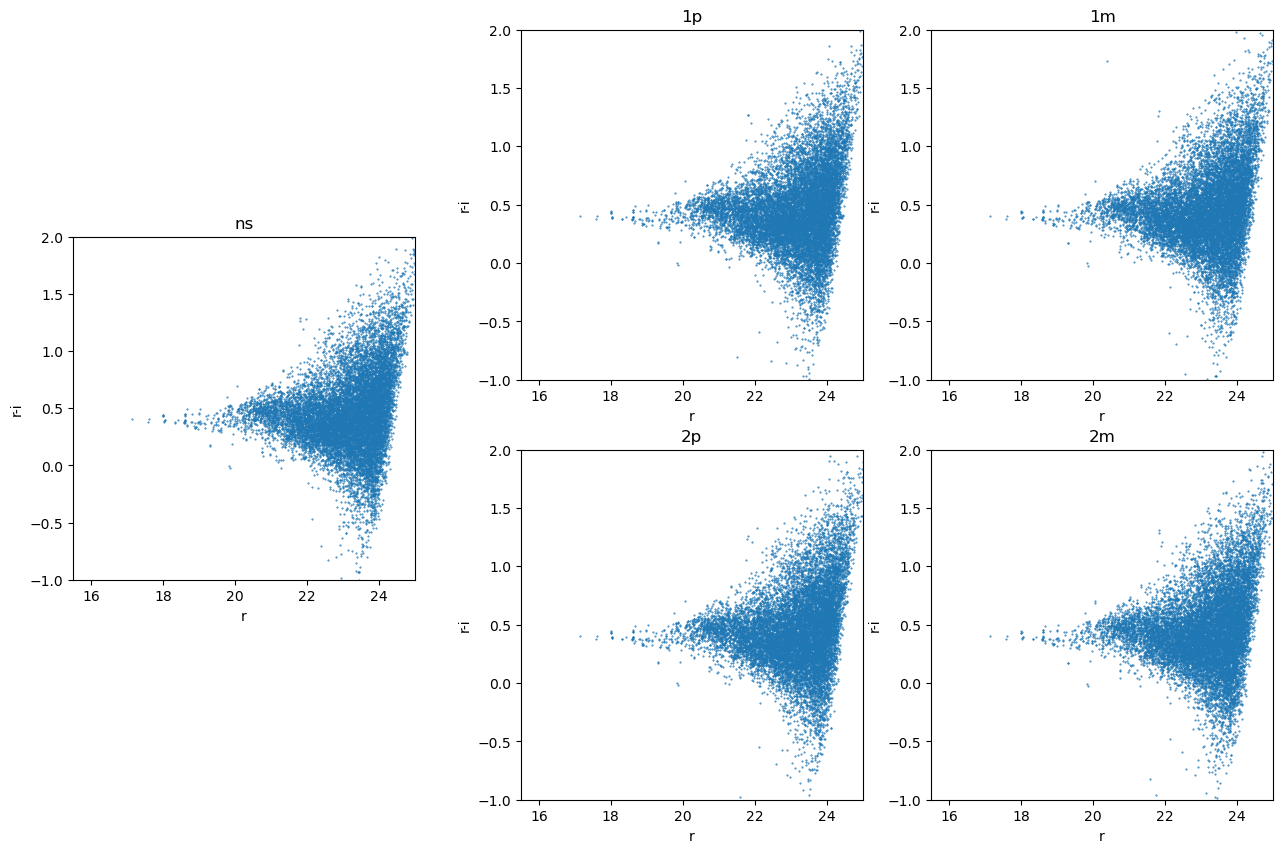

In [28]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes[1][0].set_visible(False)

axes[0][0].set_position([0.1,0.33,0.228,0.343])

point_size = 0.8
point_alpha = 0.7

# ns 
axes[0][0].scatter(shear_table_wl_ns['wmom_band_mag_r'], shear_table_wl_ns['wmom_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0][0].set_title("ns")

# 1p
axes[0][1].scatter(shear_table_wl_1p['wmom_band_mag_r'], shear_table_wl_1p['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[0][1].set_title("1p")

# 1m
axes[0][2].scatter(shear_table_wl_1m['wmom_band_mag_r'], shear_table_wl_1m['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[0][2].set_title("1m")

# 2p
axes[1][1].scatter(shear_table_wl_2p['wmom_band_mag_r'], shear_table_wl_2p['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[1][1].set_title("2p")

# 2m
axes[1][2].scatter(shear_table_wl_2m['wmom_band_mag_r'], shear_table_wl_2m['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[1][2].set_title("2m")

# apply formatting to all subplots
for ax in fig.axes:
    ax.set_ylabel('r-i')
    ax.set_xlabel('r')
    ax.set_ylim([-1,2])
    ax.set_xlim([15.5,25])
    # ax.plot([19,23],[0.4,0.3], color='r', linewidth=0.7)
    # ax.plot([19,23],[0.6,0.5], color='r', linewidth=0.7)

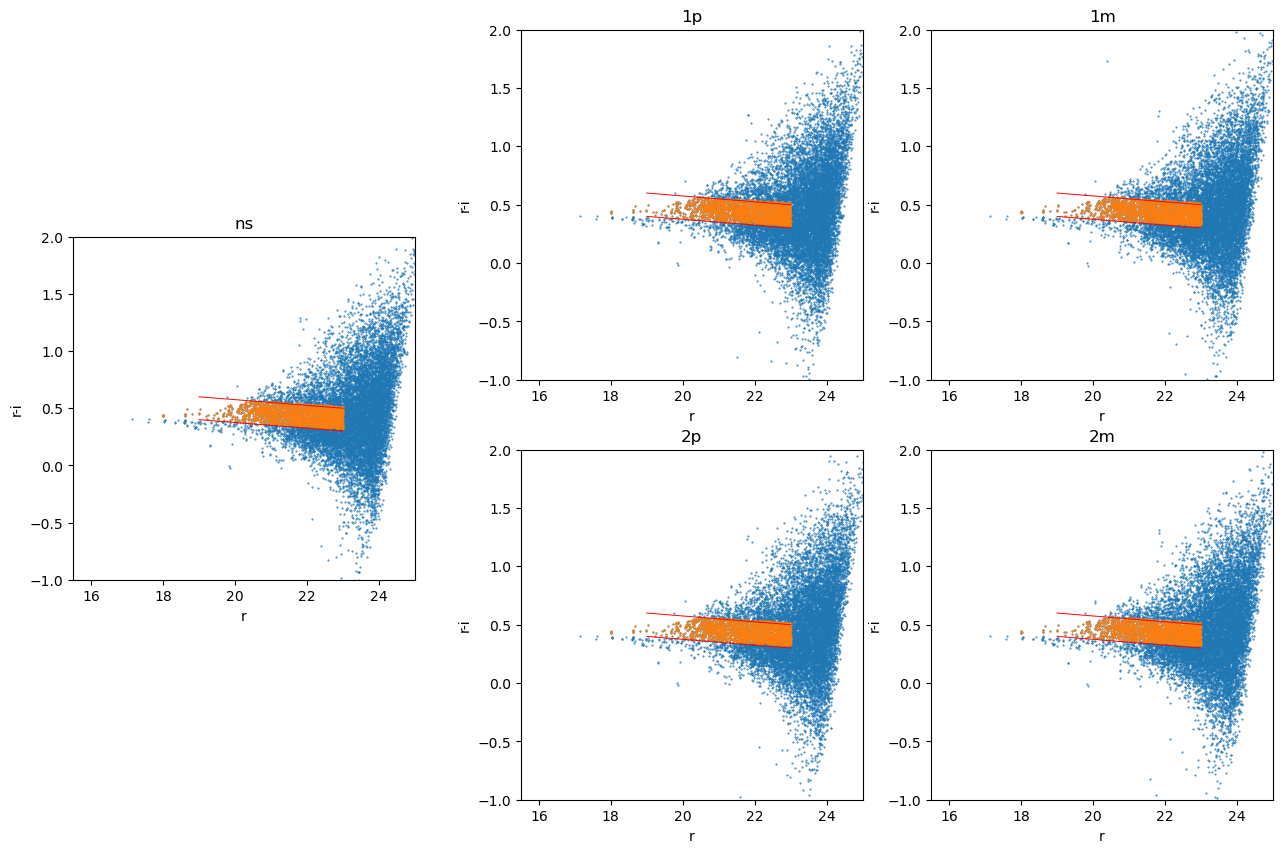

In [29]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes[1][0].set_visible(False)

axes[0][0].set_position([0.1,0.33,0.228,0.343])

point_size = 0.8
point_alpha = 0.7

# ns 
axes[0][0].scatter(shear_table_wl_ns['wmom_band_mag_r'], shear_table_wl_ns['wmom_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0][0].scatter(shear_table_wl_ns['wmom_band_mag_r'].iloc[idx_ns].iloc[idx2_ns], 
           shear_table_wl_ns['wmom_band_mag_r'].iloc[idx_ns].iloc[idx2_ns]-shear_table_wl_ns['wmom_band_mag_i'].iloc[idx_ns].iloc[idx2_ns], 
           marker='.', s=point_size) #red sequence galaxies
axes[0][0].set_title("ns")

# 1p
axes[0][1].scatter(shear_table_wl_1p['wmom_band_mag_r'], shear_table_wl_1p['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[0][1].scatter(shear_table_wl_1p['wmom_band_mag_r'].iloc[idx_1p].iloc[idx2_1p], 
           shear_table_wl_1p['wmom_band_mag_r'].iloc[idx_1p].iloc[idx2_1p]-shear_table_wl_1p['wmom_band_mag_i'].iloc[idx_1p].iloc[idx2_1p], 
           marker='.', s=point_size)
axes[0][1].set_title("1p")

# 1m
axes[0][2].scatter(shear_table_wl_1m['wmom_band_mag_r'], shear_table_wl_1m['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[0][2].scatter(shear_table_wl_1m['wmom_band_mag_r'].iloc[idx_1m].iloc[idx2_1m], 
           shear_table_wl_1m['wmom_band_mag_r'].iloc[idx_1m].iloc[idx2_1m]-shear_table_wl_1m['wmom_band_mag_i'].iloc[idx_1m].iloc[idx2_1m], 
           marker='.', s=point_size)
axes[0][2].set_title("1m")

# 2p
axes[1][1].scatter(shear_table_wl_2p['wmom_band_mag_r'], shear_table_wl_2p['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[1][1].scatter(shear_table_wl_2p['wmom_band_mag_r'].iloc[idx_2p].iloc[idx2_2p], 
           shear_table_wl_2p['wmom_band_mag_r'].iloc[idx_2p].iloc[idx2_2p]-shear_table_wl_2p['wmom_band_mag_i'].iloc[idx_2p].iloc[idx2_2p], 
           marker='.', s=point_size)
axes[1][1].set_title("2p")

# 2m
axes[1][2].scatter(shear_table_wl_2m['wmom_band_mag_r'], shear_table_wl_2m['wmom_color_mag_r-i'], 
           marker='.', s=point_size) 
axes[1][2].scatter(shear_table_wl_2m['wmom_band_mag_r'].iloc[idx_2m].iloc[idx2_2m], 
           shear_table_wl_2m['wmom_band_mag_r'].iloc[idx_2m].iloc[idx2_2m]-shear_table_wl_2m['wmom_band_mag_i'].iloc[idx_2m].iloc[idx2_2m], 
           marker='.', s=point_size)
axes[1][2].set_title("2m")

# apply formatting to all subplots
for ax in fig.axes:
    ax.set_ylabel('r-i')
    ax.set_xlabel('r')
    ax.set_ylim([-1,2])
    ax.set_xlim([15.5,25])
    ax.plot([19,23],[0.4,0.3], color='r', linewidth=0.7)
    ax.plot([19,23],[0.6,0.5], color='r', linewidth=0.7)

In [30]:
RS_id_list_ns = shear_table_wl_ns['id'].iloc[idx_ns].iloc[idx2_ns]
RS_id_list_1p = shear_table_wl_1p['id'].iloc[idx_1p].iloc[idx2_1p]
RS_id_list_1m = shear_table_wl_1m['id'].iloc[idx_1m].iloc[idx2_1m]
RS_id_list_2p = shear_table_wl_2p['id'].iloc[idx_2p].iloc[idx2_2p]
RS_id_list_2m = shear_table_wl_2m['id'].iloc[idx_2m].iloc[idx2_2m]

In [31]:
print(len(RS_id_list_ns))
print(len(RS_id_list_1p))
print(len(RS_id_list_1m))
print(len(RS_id_list_2p))
print(len(RS_id_list_2m))

2155
2139
2189
2163
2194


In [32]:
# Filter out rows where the 'dataid' column matches any value in RS_id_list
shear_table_wl_ns = shear_table_wl_ns[~shear_table_wl_ns['id'].isin(RS_id_list_ns)]
shear_table_wl_1p = shear_table_wl_1p[~shear_table_wl_1p['id'].isin(RS_id_list_1p)]
shear_table_wl_1m = shear_table_wl_1m[~shear_table_wl_1m['id'].isin(RS_id_list_1m)]
shear_table_wl_2p = shear_table_wl_2p[~shear_table_wl_2p['id'].isin(RS_id_list_2p)]
shear_table_wl_2m = shear_table_wl_2m[~shear_table_wl_2m['id'].isin(RS_id_list_2m)]

In [33]:
print(len(shear_table_wl_ns))
print(len(shear_table_wl_1p))
print(len(shear_table_wl_1m))
print(len(shear_table_wl_2p))
print(len(shear_table_wl_2m))

9145
9082
8991
9141
9062


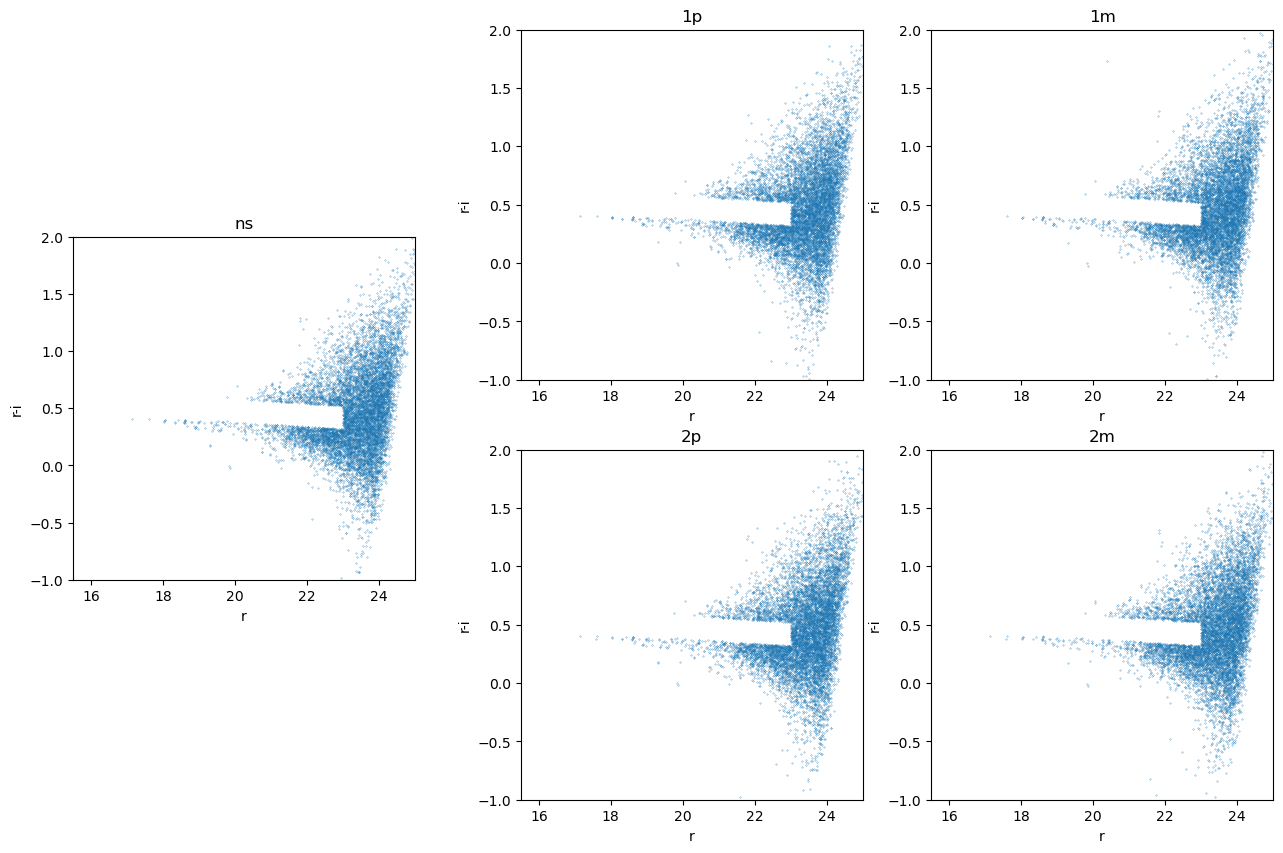

In [34]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes[1][0].set_visible(False)

axes[0][0].set_position([0.1,0.33,0.228,0.343])

point_size = 0.8
point_alpha = 0.7

# ns 
axes[0][0].scatter(shear_table_wl_ns['wmom_band_mag_r'], shear_table_wl_ns['wmom_color_mag_r-i'], 
           marker='.', s=0.2) # all galaxies
axes[0][0].set_title("ns")

# 1p
axes[0][1].scatter(shear_table_wl_1p['wmom_band_mag_r'], shear_table_wl_1p['wmom_color_mag_r-i'], 
           marker='.', s=0.2)
axes[0][1].set_title("1p")

# 1m
axes[0][2].scatter(shear_table_wl_1m['wmom_band_mag_r'], shear_table_wl_1m['wmom_color_mag_r-i'], 
           marker='.', s=0.2)
axes[0][2].set_title("1m")

# 2p
axes[1][1].scatter(shear_table_wl_2p['wmom_band_mag_r'], shear_table_wl_2p['wmom_color_mag_r-i'], 
           marker='.', s=0.2)
axes[1][1].set_title("2p")

# 2m
axes[1][2].scatter(shear_table_wl_2m['wmom_band_mag_r'], shear_table_wl_2m['wmom_color_mag_r-i'], 
           marker='.', s=0.2) 
axes[1][2].set_title("2m")

# apply formatting to all subplots
for ax in fig.axes:
    ax.set_ylabel('r-i')
    ax.set_xlabel('r')
    ax.set_ylim([-1,2])
    ax.set_xlim([15.5,25])

In [35]:
ra = shear_table_wl_ns['ra']
dec = shear_table_wl_ns['dec']
e1 = shear_table_wl_ns['wmom_g_1']
e2 = shear_table_wl_ns['wmom_g_2']
# e_err = shear_table_wl['i_hsmShapeRegauss_sigma']

In [36]:
len(ra)

9145

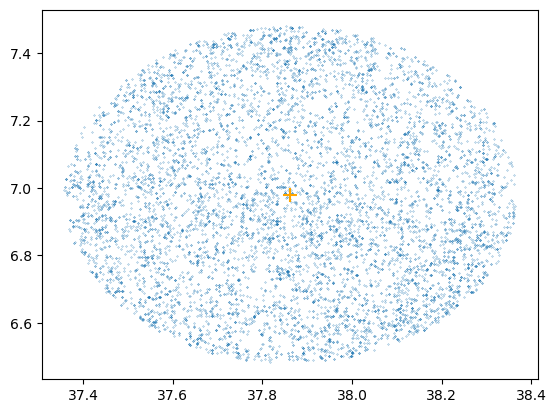

In [37]:
plt.scatter(ra, dec, marker='.', s=0.2)
plt.scatter([ra_bcg], [dec_bcg], marker='+', s=100, color='orange')

### Check lines of overdensity

Lines of overdensity: imperfect overlap of objects between patches/tracts.

(Outdated, but code might be useful later)

In [38]:
# patch_list = []

# for ref in butler.registry.queryDatasets('deepCoaddCell', collections=cell_collection, band='i'):
#     patch_list.append(butler.query_datasets('deepCoaddCell', 
#                                                  collections=cell_collection,
#                                                  skymap = 'lsst_cells_v1',
#                                                  band = 'i',
#                                                  tract=ref.dataId['tract'],
#                                                  patch=ref.dataId['patch'])[0])

In [39]:
# segs = []

# for ref in patch_list:
    
#     coadd = butler.get('deepCoaddCell',
#                       collections=cell_collection,
#                       skymap = 'lsst_cells_v1',
#                       band = 'i',
#                       tract=ref.dataId['tract'],
#                       patch=ref.dataId['patch'])

#     wcs = coadd.wcs
#     bbox = coadd.inner_bbox

#     coadd_corners = coadd.inner_bbox.getCorners()

#     for index, corner in enumerate(coadd_corners):
#         corner_coord_start = wcs.pixelToSky(corner.getX(), corner.getY())
#         if index < 3:
#             corner_coord_end = wcs.pixelToSky(coadd_corners[index+1].getX(), coadd_corners[index+1].getY())
#         else:
#             corner_coord_end = wcs.pixelToSky(coadd_corners[0].getX(), coadd_corners[0].getY())
    
#         start_ra = corner_coord_start[0].asDegrees()
#         start_dec = corner_coord_start[1].asDegrees()
    
#         end_ra = corner_coord_end[0].asDegrees()
#         end_dec = corner_coord_end[1].asDegrees()

#         segs.append(((start_ra, start_dec), (end_ra, end_dec)))

#     del coadd
#     gc.collect()

In [40]:
# plt.scatter(ra, dec, marker='.', s=0.2)
# plt.scatter([ra_bcg], [dec_bcg], marker='+', s=100, color='orange')
# for seg in segs:
#     plt.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.4)
# plt.show()

### Recombine the shear type catalogs prior to the calibration step

In [41]:
shear_table_wl = pd.concat([shear_table_wl_ns, shear_table_wl_1p, shear_table_wl_1m, shear_table_wl_2p, shear_table_wl_2m])

# Looking at shear outputs

## Check g1/g2 and PSF ellipticities

Check that the PSF and object ellipticities average to ~0

In [42]:
# print mean values
print("Mean of psfrec_g_1: ", shear_table['psfrec_g_1'].median())
print("Mean of psfrec_g_2: ", shear_table['psfrec_g_2'].median())
print("Mean of wmom_g_1: ", shear_table['wmom_g_1'].median())
print("Mean of wmom_g_2: ", shear_table['wmom_g_2'].median())

Mean of psfrec_g_1:  -0.04231753200292587
Mean of psfrec_g_2:  -5.4437059588963166e-05
Mean of wmom_g_1:  0.0003956527216359973
Mean of wmom_g_2:  0.000510137586388737


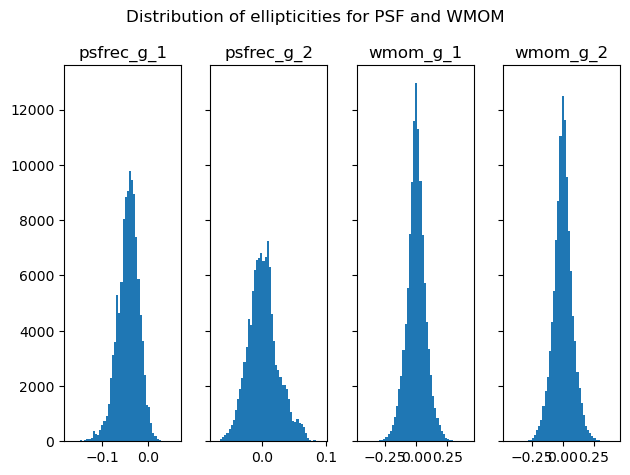

In [43]:
n_bins = 50

fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].hist(shear_table['psfrec_g_1'], bins=n_bins)
axs[0].set_title('psfrec_g_1')
axs[1].hist(shear_table['psfrec_g_2'], bins=n_bins)
axs[1].set_title('psfrec_g_2')
axs[2].hist(shear_table['wmom_g_1'], bins=n_bins)
axs[2].set_title('wmom_g_1')
axs[3].hist(shear_table['wmom_g_2'], bins=n_bins)
axs[3].set_title('wmom_g_2')

fig.suptitle("Distribution of ellipticities for PSF and WMOM")

plt.show()

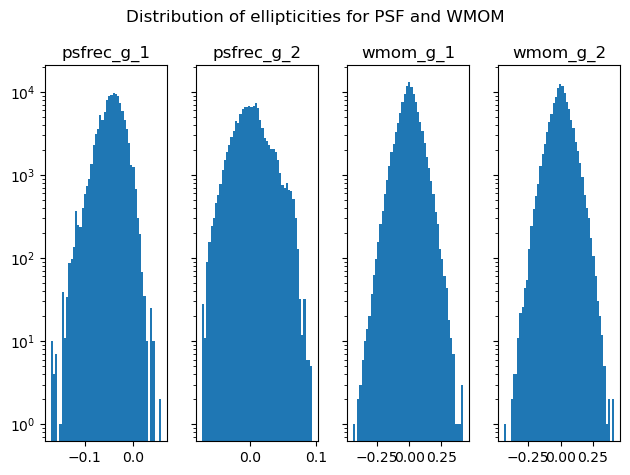

In [44]:
n_bins = 50

fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].hist(shear_table['psfrec_g_1'], bins=n_bins)
axs[0].set_yscale('log')
axs[0].set_title('psfrec_g_1')
axs[1].hist(shear_table['psfrec_g_2'], bins=n_bins)
axs[1].set_title('psfrec_g_2')
axs[1].set_yscale('log')
axs[2].hist(shear_table['wmom_g_1'], bins=n_bins)
axs[2].set_title('wmom_g_1')
axs[2].set_yscale('log')
axs[3].hist(shear_table['wmom_g_2'], bins=n_bins)
axs[3].set_title('wmom_g_2')
axs[3].set_yscale('log')

fig.suptitle("Distribution of ellipticities for PSF and WMOM")

plt.show()

PSG g1 appears less biased than last time, though is still pretty obiously biased. (Previously, 1 band with 4 whole tracts, had -0.25.). However, this does not seem to present a problem with the shape measurements.

## Determining tangential & cross shear

In [45]:
# imports and definitions
from numpy.linalg import inv
import scipy.integrate as integrate
from matplotlib import cm

import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

# Radial binning, either in Mpc or degrees
bins_mpc = clmm.make_bins(0.7,5,nbins=5, method='evenlog10width')
bins_deg = clmm.make_bins(0.1,0.5,nbins=5, method='evenlog10width')

bin_mid_mpc = [(0.5 * (bins_mpc[i] + bins_mpc[i+1])) for i in range(len(bins_mpc)-1)]

# polar angle of source galaxy relative to BCG
# from -pi to pi
shear_table_wl_ns['phi'] = np.arctan2(shear_table_wl_ns['dec'] - dec_bcg, (ra_bcg - shear_table_wl_ns['ra'])*np.cos(np.deg2rad(dec_bcg)))
shear_table_wl_1p['phi'] = np.arctan2(shear_table_wl_1p['dec'] - dec_bcg, (ra_bcg - shear_table_wl_1p['ra'])*np.cos(np.deg2rad(dec_bcg)))
shear_table_wl_1m['phi'] = np.arctan2(shear_table_wl_1m['dec'] - dec_bcg, (ra_bcg - shear_table_wl_1m['ra'])*np.cos(np.deg2rad(dec_bcg)))
shear_table_wl_2p['phi'] = np.arctan2(shear_table_wl_2p['dec'] - dec_bcg, (ra_bcg - shear_table_wl_2p['ra'])*np.cos(np.deg2rad(dec_bcg)))
shear_table_wl_2m['phi'] = np.arctan2(shear_table_wl_2m['dec'] - dec_bcg, (ra_bcg - shear_table_wl_2m['ra'])*np.cos(np.deg2rad(dec_bcg)))

shear_diff = 0.02

Definitions of tangential and cross shear used:
$$ \gamma_t = -\gamma_1\cos(2\phi)-\gamma_2\sin(2\phi) $$
$$ \gamma_\times = \gamma_1\sin(2\phi)-\gamma_2\cos(2\phi) $$

### Individual Phi

This section will attempt to measure $\gamma_t$ and $\gamma_\times$ by:
- Calculate individual $\phi$ for each galaxy
- Calculate $\gamma_t$ and $\gamma_\times$ for each galaxy
- Calculate the response R from all galaxies, no binning
- Apply R to averaged / binned $\gamma_t,\gamma_\times$

Can R, with artificial shear applied on `g1/g2`, be applied to $\gamma_t,\gamma_\times$?

In [46]:
p1_mean = shear_table_wl_1p['wmom_g_1'].mean()
m1_mean = shear_table_wl_1m['wmom_g_1'].mean()
p2_mean = shear_table_wl_2p['wmom_g_2'].mean()
m2_mean = shear_table_wl_2m['wmom_g_2'].mean()

r_matrix = [[0, 0],[0, 0]]

r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff # this should be right
# r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore?
# r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff # ignore?
r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff # and this should be right

r_matrix_inv = inv(r_matrix)

In [47]:
# calculate tangential / cross shear components for each galaxy
shear_table_wl_ns['shear_t'] = -shear_table_wl_ns['wmom_g_1'] * np.cos(2*shear_table_wl_ns['phi']) \
                                - shear_table_wl_ns['wmom_g_2'] * np.sin(2*shear_table_wl_ns['phi'])
shear_table_wl_ns['shear_x'] = shear_table_wl_ns['wmom_g_1'] * np.sin(2*shear_table_wl_ns['phi']) \
                                - shear_table_wl_ns['wmom_g_2'] * np.cos(2*shear_table_wl_ns['phi'])

In [48]:
# define radial bins
dig_rad_bins_ns = np.digitize(shear_table_wl_ns['deg_sep'], bins_deg)

In [49]:
# bin tangential and cross shears by radial bins
tan_cross_shears = np.zeros([len(bins_deg)-1, 2]) # binned tangential and cross shear

for i in range(0, len(bins_deg)-1):
    bin_filt_ns = dig_rad_bins_ns == i+1

    # print number of galaxies in each bin
    print("Rows in bin ", i, " :", len(shear_table_wl_ns['shear_t'][bin_filt_ns]))

    # calulcate mean t and x shears
    mean_t_shear = shear_table_wl_ns['shear_t'][bin_filt_ns].mean() # mean g1
    mean_x_shear = shear_table_wl_ns['shear_x'][bin_filt_ns].mean() # mean g2

    # apply calibration 
    shear_cal = r_matrix_inv.dot([mean_t_shear, mean_x_shear])

    tan_cross_shears[i] = shear_cal

Rows in bin  0  : 318
Rows in bin  1  : 604
Rows in bin  2  : 1081
Rows in bin  3  : 2062
Rows in bin  4  : 4697


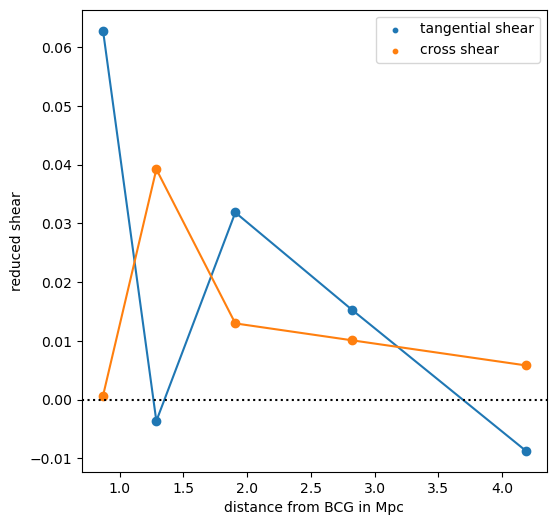

In [50]:
fig, axes = plt.subplots(1,1, figsize=(6,6))

point_size = 40
point_alpha = 1

# g1 calibrated
axes.scatter(bin_mid_mpc, tan_cross_shears[:,0],
             marker='.', s=point_size, label='tangential shear')
axes.plot(bin_mid_mpc, tan_cross_shears[:,0], '-o')

axes.scatter(bin_mid_mpc, tan_cross_shears[:,1],
             marker='.', s=point_size, label='cross shear')
axes.plot(bin_mid_mpc, tan_cross_shears[:,1], '-o')

# axes.set_ylim(-1, 1)

axes.set_ylabel("reduced shear")
axes.set_xlabel("distance from BCG in Mpc")

axes.legend(loc="upper right")
plt.axhline(0.0, color='k', ls=':')

plt.show()

The attempts at measuring the reduced shear below in the remaining sections are more experimental.

### Radial and Polar Angle Binning with a Global R

This section will attempt to measure $\gamma_t$ and $\gamma_\times$ by:
- **Calculate the response R from all galaxies, no binning**
- Binning galaxies by radial distance of BCG
- Additionally binning galaxies by polar angle $\phi$, relative to the BCG
- Apply calculated R to the averaged $g_1$ and $g_2$ of each bin to calibrate shears
- Calculate average $\gamma_t$ and $\gamma_\times$ for each bin

In [51]:
p1_mean = shear_table_wl_1p['wmom_g_1'].mean()
m1_mean = shear_table_wl_1m['wmom_g_1'].mean()
p2_mean = shear_table_wl_2p['wmom_g_2'].mean()
m2_mean = shear_table_wl_2m['wmom_g_2'].mean()

In [52]:
r_matrix = [[0, 0],[0, 0]]

r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff # this should be right
# r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore?
# r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff # ignore?
r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff # and this should be right

In [53]:
r_matrix_inv = inv(r_matrix)

In [54]:
# -pi to pi in increments of pi/3, in radians
phi_bins = np.linspace(-np.pi, np.pi, num=5) # needs to be an odd number

In [55]:
# bin the rows for each shear type catalog
dig_rad_bins_ns = np.digitize(shear_table_wl_ns['deg_sep'], bins_deg)
dig_phi_bins_ns = np.digitize(shear_table_wl_ns['phi'], phi_bins)

dig_rad_bins_1p = np.digitize(shear_table_wl_1p['deg_sep'], bins_deg)
dig_phi_bins_1p = np.digitize(shear_table_wl_1p['phi'], phi_bins)

dig_rad_bins_1m = np.digitize(shear_table_wl_1m['deg_sep'], bins_deg)
dig_phi_bins_1m = np.digitize(shear_table_wl_1m['phi'], phi_bins)

dig_rad_bins_2p = np.digitize(shear_table_wl_2p['deg_sep'], bins_deg)
dig_phi_bins_2p = np.digitize(shear_table_wl_2p['phi'], phi_bins)

dig_rad_bins_2m = np.digitize(shear_table_wl_2m['deg_sep'], bins_deg)
dig_phi_bins_2m = np.digitize(shear_table_wl_2m['phi'], phi_bins)

In [56]:
len(phi_bins)

5

In [57]:
gs = np.zeros([len(bins_deg)-1, len(phi_bins)-1, 2]) # indexing is theta, phi, then g1/g2 index
gs_cal = np.zeros([len(bins_deg)-1, len(phi_bins)-1, 2]) # calibrated g1/g2s
tan_cross_shears = np.zeros([len(bins_deg)-1, len(phi_bins)-1, 2]) # binned tangential and cross shear

for i in range(0, len(bins_deg)-1):
    for j in range(0, len(phi_bins)-1):
        bin_filt_ns = dig_rad_bins_ns == i+1
        bin_filt_ns &= dig_phi_bins_ns == j+1
        
        gs[i][j][0] = shear_table_wl_ns['wmom_g_1'][bin_filt_ns].mean() # mean g1
        gs[i][j][1] = shear_table_wl_ns['wmom_g_2'][bin_filt_ns].mean() # mean g2

        g_cal = r_matrix_inv.dot(gs[i][j])

        gs_cal[i][j][0] = g_cal[0]
        gs_cal[i][j][1] = g_cal[1]

        mean_phi = shear_table_wl_ns['phi'][bin_filt_ns].mean()

        tan_cross_shears[i][j][0] = -g_cal[0] * np.cos(2*mean_phi) - g_cal[1] * np.sin(2*mean_phi)
        tan_cross_shears[i][j][1] = g_cal[0] * np.sin(2*mean_phi) - g_cal[1] * np.cos(2*mean_phi)

In [58]:
len(phi_bins)-1

4

In [59]:
# average over each phi bin for each radial bin
tan_mean_shears = np.zeros([len(bins_deg)-1])
cross_mean_shears = np.zeros([len(bins_deg)-1])

for i in range(0, len(bins_deg)-1):
    tan_temp = 0
    cross_temp = 0
    for j in range(0, len(phi_bins)-1):
        tan_temp += tan_cross_shears[i][j][0]
        cross_temp += tan_cross_shears[i][j][1]
    tan_mean_shears[i] = tan_temp / (len(phi_bins)-1)
    cross_mean_shears[i] = cross_temp / (len(phi_bins)-1)

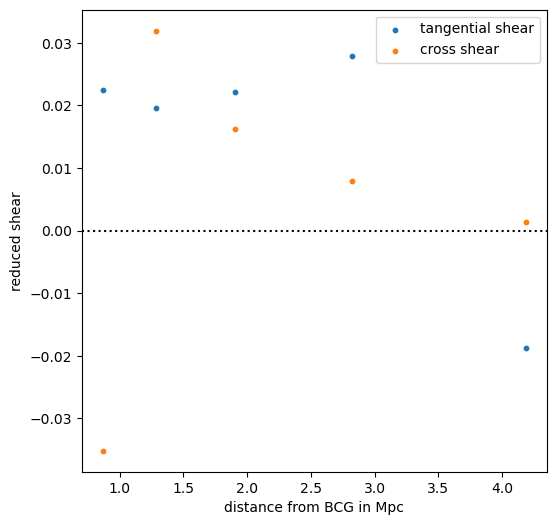

In [60]:
fig, axes = plt.subplots(1,1, figsize=(6,6))

point_size = 40
point_alpha = 1

# g1 calibrated
axes.scatter(bin_mid_mpc, tan_mean_shears, 
             marker='.', s=point_size, label='tangential shear')

axes.scatter(bin_mid_mpc, cross_mean_shears, 
             marker='.', s=point_size, label='cross shear')

# axes.set_ylim(-1, 1)

axes.set_ylabel("reduced shear")
axes.set_xlabel("distance from BCG in Mpc")

axes.legend(loc="upper right")
plt.axhline(0.0, color='k', ls=':')

plt.show()

### Radial and Polar Angle Binning with R for each radial bin

This section will attempt to measure $\gamma_t$ and $\gamma_\times$ by:
- Binning galaxies by radial distance of BCG
- **Calculate the response R from all galaxies for each radial bin**
- Additionally binning galaxies by polar angle $\phi$, relative to the BCG
- Apply calculated R to the averaged $g_1$ and $g_2$ of each bin to calibrate shears
- Calculate average $\gamma_t$ and $\gamma_\times$ for each bin

In [61]:
# -pi to pi in increments of pi/3, in radians
phi_bins = np.linspace(-np.pi, np.pi, num=5)

In [62]:
# bin the rows for each shear type catalog
dig_rad_bins_ns = np.digitize(shear_table_wl_ns['deg_sep'], bins_deg)
dig_phi_bins_ns = np.digitize(shear_table_wl_ns['phi'], phi_bins)

dig_rad_bins_1p = np.digitize(shear_table_wl_1p['deg_sep'], bins_deg)
dig_phi_bins_1p = np.digitize(shear_table_wl_1p['phi'], phi_bins)

dig_rad_bins_1m = np.digitize(shear_table_wl_1m['deg_sep'], bins_deg)
dig_phi_bins_1m = np.digitize(shear_table_wl_1m['phi'], phi_bins)

dig_rad_bins_2p = np.digitize(shear_table_wl_2p['deg_sep'], bins_deg)
dig_phi_bins_2p = np.digitize(shear_table_wl_2p['phi'], phi_bins)

dig_rad_bins_2m = np.digitize(shear_table_wl_2m['deg_sep'], bins_deg)
dig_phi_bins_2m = np.digitize(shear_table_wl_2m['phi'], phi_bins)

In [63]:
len(phi_bins)

5

In [64]:
gs = np.zeros([len(bins_deg)-1, len(phi_bins)-1, 2]) # indexing is theta, phi, then g1/g2 index
gs_cal = np.zeros([len(bins_deg)-1, len(phi_bins)-1, 2]) # calibrated g1/g2s
tan_cross_shears = np.zeros([len(bins_deg)-1, len(phi_bins)-1, 2]) # binned tangential and cross shear

for i in range(0, len(bins_deg)-1):
    
    # calibrate the g1/g2s for each bin
    bin_filt_1p = dig_rad_bins_1p == i+1
    p1_mean = shear_table_wl_1p['wmom_g_1'][bin_filt_1p].mean()

    bin_filt_1m = dig_rad_bins_1m == i+1
    m1_mean = shear_table_wl_1m['wmom_g_1'][bin_filt_1m].mean()

    bin_filt_2p = dig_rad_bins_2p == i+1
    p2_mean = shear_table_wl_2p['wmom_g_2'][bin_filt_2p].mean()

    bin_filt_2m = dig_rad_bins_2m == i+1
    m2_mean = shear_table_wl_2m['wmom_g_2'][bin_filt_2m].mean()

    # calculate R for the bin
    r_matrix = [[0, 0],[0, 0]]
    r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff
    # r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore for now
    # r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff # ignore for now
    r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff

    # r11s.append(r_matrix[0][0])
    # r22s.append(r_matrix[1][1])

    r_matrix_inv = inv(r_matrix)
    
    for j in range(0, len(phi_bins)-1):
        
        bin_filt_ns = dig_rad_bins_ns == i+1
        bin_filt_ns &= dig_phi_bins_ns == j+1
        
        gs[i][j][0] = shear_table_wl_ns['wmom_g_1'][bin_filt_ns].mean() # mean g1
        gs[i][j][1] = shear_table_wl_ns['wmom_g_2'][bin_filt_ns].mean() # mean g2

        g_cal = r_matrix_inv.dot(gs[i][j])

        gs_cal[i][j][0] = g_cal[0]
        gs_cal[i][j][1] = g_cal[1]

        mean_phi = shear_table_wl_ns['phi'][bin_filt_ns].mean()

        tan_cross_shears[i][j][0] = -g_cal[0] * np.cos(2*mean_phi) - g_cal[1] * np.sin(2*mean_phi)
        tan_cross_shears[i][j][1] = g_cal[0] * np.sin(2*mean_phi) - g_cal[1] * np.cos(2*mean_phi)

In [65]:
# average over each phi bin for each radial bin

tan_mean_shears = np.zeros([len(bins_deg)-1])
cross_mean_shears = np.zeros([len(bins_deg)-1])

for i in range(0, len(bins_deg)-1):
    tan_temp = 0
    cross_temp = 0
    for j in range(0, len(phi_bins)-1):
        tan_temp += tan_cross_shears[i][j][0]
        cross_temp += tan_cross_shears[i][j][1]
    tan_mean_shears[i] = tan_temp / (len(phi_bins)-1)
    cross_mean_shears[i] = cross_temp / (len(phi_bins)-1)

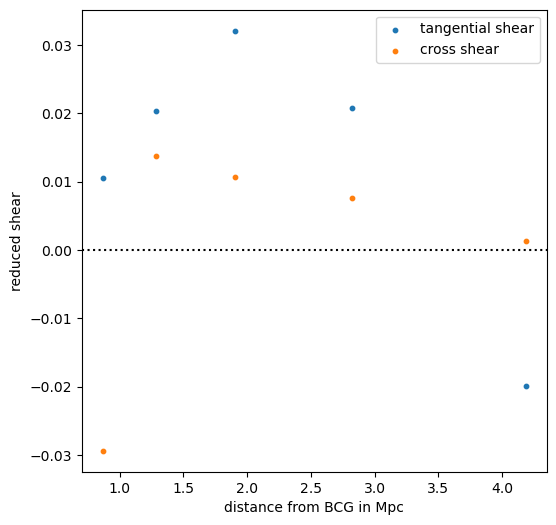

In [66]:
fig, axes = plt.subplots(1,1, figsize=(6,6))

point_size = 40
point_alpha = 1

# g1 calibrated
axes.scatter(bin_mid_mpc, tan_mean_shears, 
             marker='.', s=point_size, label='tangential shear')

axes.scatter(bin_mid_mpc, cross_mean_shears, 
             marker='.', s=point_size, label='cross shear')

# axes.set_ylim(-1, 1)

axes.set_ylabel("reduced shear")
axes.set_xlabel("distance from BCG in Mpc")

axes.legend(loc="upper right")
plt.axhline(0.0, color='k', ls=':')

plt.show()

### Radial and Polar Angle Binning with Separate Rs in each bin

This section will attempt to measure $\gamma_t$ and $\gamma_\times$ by:
- Binning galaxies by radial distance of BCG
- Additionally binning galaxies by polar angle $\phi$, relative to the BCG
- Calculate the response R for each individual bin
- Apply calculated R to the averaged $g_1$ and $g_2$ of each bin to calibrate shears
- Calculate average $\gamma_t$ and $\gamma_\times$ for each bin

The usefulness of separating R by both radial and polar bin is TBD. It may be that too many bins will reduce the precision of R from increase in shape noise.

In [67]:
# -pi to pi in increments of pi/3, in radians
phi_bins = np.linspace(-np.pi, np.pi, num=5) # num=7

In [68]:
# bin the rows for each shear type catalog
dig_rad_bins_ns = np.digitize(shear_table_wl_ns['deg_sep'], bins_deg)
dig_phi_bins_ns = np.digitize(shear_table_wl_ns['phi'], phi_bins)

dig_rad_bins_1p = np.digitize(shear_table_wl_1p['deg_sep'], bins_deg)
dig_phi_bins_1p = np.digitize(shear_table_wl_1p['phi'], phi_bins)

dig_rad_bins_1m = np.digitize(shear_table_wl_1m['deg_sep'], bins_deg)
dig_phi_bins_1m = np.digitize(shear_table_wl_1m['phi'], phi_bins)

dig_rad_bins_2p = np.digitize(shear_table_wl_2p['deg_sep'], bins_deg)
dig_phi_bins_2p = np.digitize(shear_table_wl_2p['phi'], phi_bins)

dig_rad_bins_2m = np.digitize(shear_table_wl_2m['deg_sep'], bins_deg)
dig_phi_bins_2m = np.digitize(shear_table_wl_2m['phi'], phi_bins)

In [69]:
len(phi_bins)

5

In [70]:
gs = np.zeros([len(bins_deg)-1, len(phi_bins)-1, 2]) # indexing is theta, phi, then g1/g2 index
gs_cal = np.zeros([len(bins_deg)-1, len(phi_bins)-1, 2]) # calibrated g1/g2s
tan_cross_shears = np.zeros([len(bins_deg)-1, len(phi_bins)-1, 2]) # binned tangential and cross shear

for i in range(0, len(bins_deg)-1):
    for j in range(0, len(phi_bins)-1):
        bin_filt_ns = dig_rad_bins_ns == i+1
        bin_filt_ns &= dig_phi_bins_ns == j+1
        
        gs[i][j][0] = shear_table_wl_ns['wmom_g_1'][bin_filt_ns].mean() # mean g1
        gs[i][j][1] = shear_table_wl_ns['wmom_g_2'][bin_filt_ns].mean() # mean g2

        # calibrate the g1/g2s for each bin
        bin_filt_1p = dig_rad_bins_1p == i+1
        bin_filt_1p &= dig_phi_bins_1p == j+1
        p1_mean = shear_table_wl_1p['wmom_g_1'][bin_filt_1p].mean()

        bin_filt_1m = dig_rad_bins_1m == i+1
        bin_filt_1m &= dig_phi_bins_1m == j+1
        m1_mean = shear_table_wl_1m['wmom_g_1'][bin_filt_1m].mean()

        bin_filt_2p = dig_rad_bins_2p == i+1
        bin_filt_2p &= dig_phi_bins_2p == j+1
        p2_mean = shear_table_wl_2p['wmom_g_2'][bin_filt_2p].mean()

        bin_filt_2m = dig_rad_bins_2m == i+1
        bin_filt_2m &= dig_phi_bins_2m == j+1
        m2_mean = shear_table_wl_2m['wmom_g_2'][bin_filt_2m].mean()

        r_matrix = [[0, 0],[0, 0]]
        r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff
        # r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore for now
        # r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff # ignore for now
        r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff

        r_matrix_inv = inv(r_matrix)

        g_cal = r_matrix_inv.dot(gs[i][j])

        gs_cal[i][j][0] = g_cal[0]
        gs_cal[i][j][1] = g_cal[1]

        mean_phi = shear_table_wl_ns['phi'][bin_filt_ns].mean()

        tan_cross_shears[i][j][0] = -g_cal[0] * np.cos(2*mean_phi) - g_cal[1] * np.sin(2*mean_phi)
        tan_cross_shears[i][j][1] = g_cal[0] * np.sin(2*mean_phi) - g_cal[1] * np.cos(2*mean_phi)

In [71]:
# average over each phi bin to get mean shear in the radial bin

tan_mean_shears = np.zeros([len(bins_deg)-1])
cross_mean_shears = np.zeros([len(bins_deg)-1])

for i in range(0, len(bins_deg)-1):
    tan_temp = 0
    cross_temp = 0
    for j in range(0, len(phi_bins)-1):
        tan_temp += tan_cross_shears[i][j][0]
        cross_temp += tan_cross_shears[i][j][1]
    tan_mean_shears[i] = tan_temp / (len(phi_bins)-1)
    cross_mean_shears[i] = cross_temp / (len(phi_bins)-1)

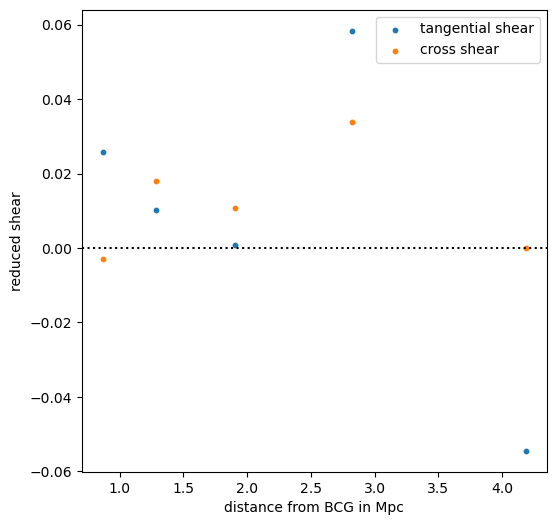

In [72]:
fig, axes = plt.subplots(1,1, figsize=(6,6))

point_size = 40
point_alpha = 1

# g1 calibrated
axes.scatter(bin_mid_mpc, tan_mean_shears, 
             marker='.', s=point_size, label='tangential shear')

axes.scatter(bin_mid_mpc, cross_mean_shears, 
             marker='.', s=point_size, label='cross shear')

# axes.set_ylim(-1, 1)

axes.set_ylabel("reduced shear")
axes.set_xlabel("distance from BCG in Mpc")

axes.legend(loc="upper right")
plt.axhline(0.0, color='k', ls=':')

plt.show()

### CLMM Attempt

In [73]:
# locally install modeling packages
# pip install pyccl
# pip install clmm

In [74]:
# galcat = GCData()
# galcat['ra'] = ra_list
# galcat['dec'] = dec_list
# galcat['e1'] = gamma1s
# galcat['e2'] = gamma2s

# galcat['z'] = np.zeros(len(ra_list)) # CLMM needs a redshift column for the source, even if not used

In [75]:
# galcat = GCData()
# galcat['ra'] = shear_table_ns['ra']
# galcat['dec'] = shear_table_ns['dec']
# # galcat['e1'] = e1
# # galcat['e2'] = e2
# galcat['e1'] = shear_table_ns['wmom_g_1']
# galcat['e2'] = shear_table_ns['wmom_g_2']
# # galcat['e_err'] = e_err/2.  # factor 2 to account for conversion between e and g

# galcat['z'] = np.zeros(len(shear_table_ns)) # CLMM needs a redshift column for the source, even if not used

In [76]:
# cluster_id = "Abell 360"
# gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')

In [77]:
# gc_object1.compute_tangential_and_cross_components(add=True)

In [78]:
# gc_object1.compute_galaxy_weights(
#         shape_component1="e1",
#         shape_component2="e2",
#         use_shape_error=True,
#         shape_component1_err="e_err",
#         shape_component2_err="e_err",
#         use_shape_noise=True,
#         weight_name="w_ls",
#         cosmo=cosmo,
#         add=True,
#     ) 

# TO-DO find/compute shape errors from metadetect
# gc_object1.compute_galaxy_weights(
#         shape_component1="e1",
#         shape_component2="e2",
#         use_shape_error=False,
#         use_shape_noise=True,
#         weight_name="w_ls",
#         cosmo=cosmo,
#         add=True,
#     )

In [79]:
# gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, use_weights=True);
# gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, use_weights=False);

In [80]:
# Check the profile table
# gc_object1.profile

In [81]:
# moo = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="nfw")

# moo.set_cosmo(cosmo)
# moo.set_concentration(4)
# moo.set_mass(1.0e15)

# z_cl = gc_object1.z

# # source properties
# # assume sources redshift following a the DESC SRD distribution. This will need updating.

# z_distrib_func = utils.redshift_distributions.desc_srd  

# # Compute first beta (e.g. eq(6) of WtGIII paper)
# beta_kwargs = {
#     "z_cl": z_cl,
#     "z_inf": 10.0,
#     "cosmo": cosmo,
#     "z_distrib_func": z_distrib_func,
# }
# beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
# beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

# rproj = np.logspace(np.log10(0.3),np.log10(7.), 100)

# gt_z = moo.eval_reduced_tangential_shear(
#     rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
# )

In [82]:
# plt.errorbar(gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
#              ls='', marker='.', label='tangential')
# plt.errorbar(gc_object1.profile['radius']*1.02, gc_object1.profile['gx'], gc_object1.profile['gx_err'], 
#              ls='', marker='.', label='cross')
# plt.plot(rproj, gt_z, label='NFW (model, not fit), M200m=1e15 Msun, c=4, n(z)=SRD', ls=':')

# plt.xscale('log')
# plt.axhline(0.0, color='k', ls=':')
# plt.ylim([-0.03,0.08])
# plt.xlim([0.7,7])
# plt.yscale('log')
# plt.xlabel('R [Mpc]')
# plt.ylabel('reduced shear')
# plt.legend(loc=1)